### Personal Settings

In [14]:
import os
import sys
from pathlib import Path

main_dir_name = 'Week'
unwanted_subdir_name = 'exercises'

for _ in range(5):
    parent_path = str(Path.cwd().parents[_]).split('/')[-1]
    if (main_dir_name in str(Path.cwd()).split('/')[-1]) and (
        unwanted_subdir_name not in str(Path.cwd()).split('/')[-1]
    ):
        weeks_dir = str(Path.cwd())

    elif (main_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):
        weeks_dir = str(Path.cwd().parents[_])

main_dir = str(Path(weeks_dir).parents[0])
sys.path.append(main_dir)

from setup.settings import *

%matplotlib notebook
%matplotlib widget
%matplotlib inline


In [15]:
import gensim
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import numpy as np
import random
from glob import glob
from string import punctuation

import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from dateutil import parser
import numpy as np
from tqdm import tqdm

from nltk.tokenize import TreebankWordTokenizer

pyLDAvis.enable_notebook()

In [16]:
import nltk
# nltk.data.path
nltk.download('stopwords', download_dir=nltk_path)
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Library/CloudStorage/OneDrive-
[nltk_data]     UvA/Teaching/CCS-2/CCS-2 Tutorial
[nltk_data]     Material/setup/Language Models/nltk/...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
print(f"Your gensim version is {gensim.__version__}. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.")
assert int(gensim.__version__[0])>=4

print(f"Your pyLDAvis version is {pyLDAvis.__version__}. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.")
assert int(pyLDAvis.__version__[0])>=3

Your gensim version is 4.1.2. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.
Your pyLDAvis version is 3.3.1. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.


LDA is probabilistic method. As a consequence, you may find slight variations in results for different runs of the model. To make sure our findings are reproducable, we have to set a seed. In addition, we have to use `distributed=False` to get reproducable findings. 

In [18]:
random.seed(2022) #initalizing random number generator
np.random.seed(2022)

In [19]:
## load data
PATH = "/Users/nyxinsane/Library/CloudStorage/OneDrive-UvA/Teaching/CCS-2/CCS-2 Tutorial Material/Week 2/exercises/articles"#use the data that we've also worked with in week 2
#PATH = 'path/to/folder/with/articles' 

In [20]:
RANDOM_N = 2000

## Helper function to read in the data.
# Don't panic if you do not understand each line of code; try to follow along--but we do not expect you to write such helper functions yourself from scratch

def read_data(listofoutlets, RANDOM_N = 2000, PATH = "/Users/nyxinsane/Library/CloudStorage/OneDrive-UvA/Teaching/CCS-2/CCS-2 Tutorial Material/Week 2/exercises/articles"#use the data that we've also worked with in week 2
):

    date = []
    title = []
    outlets = []
    texts = []
    for outlet in listofoutlets:
        print(f'Outlet: {outlet}')

        for file in random.choices(glob(f'{PATH}/*/{outlet}/*'), k=RANDOM_N):
            # format of filename: Infowars--2018-02-03--Collusion Is Dead Trump Celebrates Release of FISA Memo
            # -1 gets the last item, which is the title of the article
            # -2 gets the second last item, which is the date of the article
            date.append(file.split('--')[-2])
            title.append(file.split('--')[-1])
            with open(file) as f:
                texts.append(f.read())
                outlets.append(outlet)

    return date, title, texts, outlets

dates, title, texts, outlets = read_data(listofoutlets=['Infowars'])

Outlet: Infowars


In [21]:
date = []
title = []
outlets = []
texts = []

listofoutlets = ['Infowars']

for outlet in listofoutlets:

    path_to_outlet_directory = glob(f'{PATH}/*/Infowars/*')
    randomly_choosen_articles = random.choices(path_to_outlet_directory, k=2000)

    for filename in randomly_choosen_articles:
        # format of filename: Infowars--2018-02-03--Collusion Is Dead Trump Celebrates Release of FISA Memo

        # -1 gets the last item, which is the title of the article
        # -2 gets the second last item, which is the date of the article
        # print(file)

        title_of_article = filename.split('--')[2]
        date_of_article = filename.split('--')[1]

        # Let's place them in our empty lists
        date.append(date_of_article)
        title.append(title_of_article)
        outlets.append(outlet)

        with open(filename) as f:
            texts.append(f.read())

print('-'*20)
print(f'Date: {date[0]}')
print('-'*20)
print(f'Title: {title[0]}')
print('-'*20)
print(f'Outlet: {outlets[0]}')
print('-'*20)
print(f'Text: {texts[0][:100]}')


--------------------
Date: 2018-06-14
--------------------
Title: Tucker Carlson If You Dont Like The Direction Of The Country Have More Children
--------------------
Outlet: Infowars
--------------------
Text: Tucker Carlson told the Heritage Foundation the best way for conservatives to take back America is t


In [22]:
print(outlets[:10])

['Infowars', 'Infowars', 'Infowars', 'Infowars', 'Infowars', 'Infowars', 'Infowars', 'Infowars', 'Infowars', 'Infowars']


In [23]:
# for x in outlets:
#     if x == outlets[0]:
#         print('All outlets are Infowars')


In [24]:
# List comprehension version:
print(all(x == outlets[0] for x in outlets))

True


In [25]:
# outlets.append('News Week')
# print(all(x == outlets[0] for x in outlets))

In [26]:
len(outlets)

2000

In [27]:
type(texts[0])

str

In [28]:
texts[0][:500]

'Tucker Carlson told the Heritage Foundation the best way for conservatives to take back America is to have more children and raise them the way that you want, consistent with your beliefs.\n\nI grew up in a world where it was considered embarrassing to have more than two children, Carlson told Daily Signal editor-in-chief Rob Bluey at The Heritage Foundations 41st annual Resource Bank meeting in Fort Lauderdale, Florida last week.\n\nI dont think thats the case now among middle-class, upper middle-c'

In [29]:
texts_clean = [text.lower() for text in texts]
texts_clean=[" ".join(text.split()) for text in texts_clean]  #remove dubble spaces
texts_clean = ["".join([l for l in text if l not in punctuation]) for text in texts_clean] #remove punctuaction
texts_clean[0][:500]

'tucker carlson told the heritage foundation the best way for conservatives to take back america is to have more children and raise them the way that you want consistent with your beliefs i grew up in a world where it was considered embarrassing to have more than two children carlson told daily signal editorinchief rob bluey at the heritage foundations 41st annual resource bank meeting in fort lauderdale florida last week i dont think thats the case now among middleclass upper middleclass people '

## manually removing stopwords

In [30]:
mystopwords = set(stopwords.words('english')) # use default NLTK stopword list; alternatively:
# mystopwords = set(open('mystopwordfile.txt').readlines())  #read stopword list from a textfile with one stopword per line
texts_clean = [" ".join(word for word in text.split() if word not in mystopwords) for text in texts_clean]
texts_clean[0][:500]

'tucker carlson told heritage foundation best way conservatives take back america children raise way want consistent beliefs grew world considered embarrassing two children carlson told daily signal editorinchief rob bluey heritage foundations 41st annual resource bank meeting fort lauderdale florida last week dont think thats case among middleclass upper middleclass people said first rewarding greatest fun thing also profound thing dont like direction country children raise way want consistent b'

## Tokenize texts

In [31]:
tokenized_texts_clean = [TreebankWordTokenizer().tokenize(text) for text in texts_clean ] # tokenize texts; convert all strings to a list of tokens
tokenized_texts_clean[0][:10]

['tucker',
 'carlson',
 'told',
 'heritage',
 'foundation',
 'best',
 'way',
 'conservatives',
 'take',
 'back']

## prepare the corpus for topic modelling

In [32]:
raw_m1 = tokenized_texts_clean
id2word_m1 = corpora.Dictionary(raw_m1)   # assign a token_id to each word
print(f'My dictionary:\n{id2word_m1}')
ldacorpus_m1 = [id2word_m1.doc2bow(text) for text in raw_m1] # making out id2word tuples as a BOW representation
print(f'My document as a bag-of-words:\n{ldacorpus_m1[0]}')



My dictionary:
Dictionary(20063 unique tokens: ['41st', 'act', 'actually', 'aggression', 'aggressive']...)
My document as a bag-of-words:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2), (16, 1), (17, 1), (18, 1), (19, 4), (20, 1), (21, 4), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 4), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 3), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 3), (77, 1), (78, 1), (79, 1), (80, 3), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1)

In [33]:
lda_m1 = gensim.models.LdaModel(ldacorpus_m1, id2word=id2word_m1, num_topics=10)
lda_m1.print_topics()

[(0,
  '0.007*"said" + 0.006*"would" + 0.006*"trump" + 0.005*"one" + 0.005*"us" + 0.004*"fbi" + 0.003*"president" + 0.003*"also" + 0.003*"house" + 0.003*"kavanaugh"'),
 (1,
  '0.008*"said" + 0.008*"trump" + 0.006*"president" + 0.005*"us" + 0.004*"people" + 0.004*"one" + 0.004*"would" + 0.004*"new" + 0.003*"also" + 0.003*"state"'),
 (2,
  '0.010*"trump" + 0.009*"said" + 0.006*"people" + 0.006*"president" + 0.004*"one" + 0.004*"media" + 0.003*"new" + 0.003*"would" + 0.003*"fbi" + 0.003*"also"'),
 (3,
  '0.011*"trump" + 0.009*"said" + 0.006*"president" + 0.004*"us" + 0.004*"one" + 0.003*"house" + 0.003*"people" + 0.003*"also" + 0.003*"would" + 0.003*"white"'),
 (4,
  '0.008*"trump" + 0.005*"said" + 0.004*"fbi" + 0.004*"also" + 0.004*"us" + 0.004*"would" + 0.004*"president" + 0.003*"people" + 0.003*"news" + 0.003*"former"'),
 (5,
  '0.015*"trump" + 0.007*"president" + 0.004*"white" + 0.004*"said" + 0.004*"also" + 0.004*"people" + 0.004*"cnn" + 0.003*"told" + 0.003*"paul" + 0.003*"would"'),

### Use TFidF instead of word counts

In [34]:
ldacorpus_m2 = ldacorpus_m1 # reuse corpus from Model 1
id2word_m2 = id2word_m1 # and thus, also use id2word-mapping

tfidfcorpus_m2 = models.TfidfModel(ldacorpus_m2)

lda_m2 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2,num_topics=10)
lda_m2.print_topics(num_words=5)

[(0,
  '0.001*"trump" + 0.001*"fbi" + 0.001*"president" + 0.001*"house" + 0.001*"video"'),
 (1,
  '0.001*"jones" + 0.001*"trump" + 0.001*"said" + 0.001*"president" + 0.001*"alex"'),
 (2,
  '0.001*"trump" + 0.001*"white" + 0.001*"people" + 0.001*"house" + 0.001*"democrats"'),
 (3,
  '0.001*"trump" + 0.001*"news" + 0.001*"border" + 0.001*"fake" + 0.001*"president"'),
 (4,
  '0.001*"trump" + 0.001*"kavanaugh" + 0.001*"president" + 0.001*"infowars" + 0.001*"said"'),
 (5,
  '0.001*"trump" + 0.001*"gun" + 0.001*"shooting" + 0.001*"said" + 0.001*"president"'),
 (6,
  '0.001*"trump" + 0.001*"president" + 0.001*"border" + 0.001*"cnn" + 0.001*"said"'),
 (7,
  '0.001*"trump" + 0.001*"democrats" + 0.001*"fbi" + 0.001*"kavanaugh" + 0.001*"gun"'),
 (8,
  '0.001*"trump" + 0.001*"white" + 0.001*"democrats" + 0.001*"people" + 0.001*"said"'),
 (9,
  '0.001*"trump" + 0.001*"campaign" + 0.001*"president" + 0.001*"fbi" + 0.001*"vote"')]

### Using N-grams as features

In [35]:
documents_bigrams = [["_".join(tup) for tup in nltk.ngrams(text.split(),2)] for text in texts_clean] # creates bigrams

print(len(documents_bigrams))
documents_bigrams[0][:10] # inspect the results...


2000


['tucker_carlson',
 'carlson_told',
 'told_heritage',
 'heritage_foundation',
 'foundation_best',
 'best_way',
 'way_conservatives',
 'conservatives_take',
 'take_back',
 'back_america']

In [36]:
documents_bigrams = [["_".join(tup) for tup in nltk.ngrams(text.split(),2)] for text in texts_clean]


documents_bigrams_test = []
bigrams = []

for text in texts_clean:
    for tup in nltk.ngrams(text.split(),2):
        bigrams.append("_".join(tup))
    documents_bigrams_test.append(bigrams)

print(len(documents_bigrams_test))
print(documents_bigrams_test[0][:10])

2000
['tucker_carlson', 'carlson_told', 'told_heritage', 'heritage_foundation', 'foundation_best', 'best_way', 'way_conservatives', 'conservatives_take', 'take_back', 'back_america']


In [37]:
documents_trigrams = [["_".join(tup) for tup in nltk.ngrams(text.split(),3)] for text in texts_clean] # creates bigrams
documents_trigrams[0][:10] # inspect the results...

['tucker_carlson_told',
 'carlson_told_heritage',
 'told_heritage_foundation',
 'heritage_foundation_best',
 'foundation_best_way',
 'best_way_conservatives',
 'way_conservatives_take',
 'conservatives_take_back',
 'take_back_america',
 'back_america_children']

In [38]:
# maybe we want both unigrams and bigrams in the feature set?
documents_uniandbigrams = []
for a,b in zip([text.split() for text in texts_clean],documents_bigrams):
    documents_uniandbigrams.append(a + b)

#and let's inspect the outcomes again.
documents_uniandbigrams[0][:2]
documents_uniandbigrams[0][-162]

len(documents_uniandbigrams[0]),len(documents_bigrams[0]),len(texts_clean[0].split())

['tucker', 'carlson']

'tucker_carlson'

(325, 162, 163)

**NOTE:** TfidfVectorizer and TfidfModel are somewhat different

In [39]:
id2word_m3 = corpora.Dictionary(documents_uniandbigrams)
id2word_m3.filter_extremes(no_below=5, no_above=0.5)

ldacorpus_m3 = [id2word_m3.doc2bow(text) for text in documents_uniandbigrams] # represent each document by (token_id, token_count) tuples
tfidfcorpus_m3 = models.TfidfModel(ldacorpus_m3)

lda_m3 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m3[ldacorpus_m3],id2word=id2word_m3,num_topics=10)
lda_m3.print_topics(num_words=5)

[(0,
  '0.002*"trump" + 0.001*"gun" + 0.001*"fbi" + 0.001*"president" + 0.001*"would"'),
 (1,
  '0.001*"trump" + 0.001*"white" + 0.001*"president" + 0.001*"house" + 0.001*"cnn"'),
 (2,
  '0.002*"trump" + 0.001*"border" + 0.001*"people" + 0.001*"state" + 0.001*"president"'),
 (3,
  '0.001*"trump" + 0.001*"president" + 0.001*"media" + 0.001*"white" + 0.001*"cnn"'),
 (4,
  '0.001*"trump" + 0.001*"democrats" + 0.001*"white" + 0.001*"people" + 0.001*"news"'),
 (5,
  '0.001*"trump" + 0.001*"percent" + 0.001*"president" + 0.001*"cnn" + 0.001*"state"'),
 (6,
  '0.001*"trump" + 0.001*"school" + 0.001*"twitter" + 0.001*"gun" + 0.001*"people"'),
 (7,
  '0.001*"trump" + 0.001*"kavanaugh" + 0.001*"president" + 0.001*"fbi" + 0.001*"clinton"'),
 (8,
  '0.001*"trump" + 0.001*"vote" + 0.001*"kavanaugh" + 0.001*"cnn" + 0.001*"jones"'),
 (9,
  '0.001*"jones" + 0.001*"trump" + 0.001*"infowars" + 0.001*"border" + 0.001*"president"')]

# 2. Model evaluation

In [ ]:
# NB: CoherenceModel is only available in newer versions of gensim.
# if it's not available, consider upgrading with `pip3 install gensim -upgrade`


#The greater the number, the better is coherence score

cm1 = gensin.models.CoherenceModel(model=lda_m1, corpus=ldacorpus_m1 , dictionary=id2word_m1, coherence='u_mass')  
ch1 = cm1.get_coherence()
cm2 = models.CoherenceModel(model=lda_m2, corpus=ldacorpus_m2, dictionary= id2word_m2, coherence='u_mass')  
ch2 = cm2.get_coherence()
#cm3 = models.CoherenceModel(model=lda_m3, corpus=ldacorpus_m3, coherence='u_mass')
cm3 = models.CoherenceModel(model=lda_m3, corpus=tfidfcorpus_m3[ldacorpus_m3], dictionary= id2word_m3, coherence='u_mass')
ch3 = abs(cm3.get_coherence())

print(f"Coherence of naive model = {ch1}\nCoherence of tfidf model = {ch2}\nCoherence of bigram and unigram model = {ch3}")

In [41]:
lda_m2_bad = models.LdaModel(tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2, num_topics=10,iterations=1)
print(models.CoherenceModel(model=lda_m2_bad, corpus=tfidfcorpus_m2[ldacorpus_m2], coherence='u_mass').get_coherence())

#lda_m2_good = models.LdaModel(tfidfcorpus_m4[ldacorpus_m4], id2word=id2word_m4, num_topics=10,iterations=50, passes=5)
#print(models.CoherenceModel(model=lda_m4_good, corpus=tfidfcorpus_m4[ldacorpus_m4], coherence='u_mass').get_coherence())

-1.899273623026253


In [42]:
lda_m2_good = models.LdaModel(tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2, num_topics=10,iterations=50, passes=5)
print(models.CoherenceModel(model=lda_m2_good, corpus=tfidfcorpus_m2[ldacorpus_m2], coherence='u_mass').get_coherence())

-4.231836147135121


In [43]:
lda_m2_good.top_topics(tfidfcorpus_m2[ldacorpus_m2])

[([(0.0015532287, 'jones'),
   (0.00135823, 'infowars'),
   (0.0011806795, 'house'),
   (0.0011687276, 'said'),
   (0.001168227, 'trump'),
   (0.0011438022, 'media'),
   (0.001123663, 'democrats'),
   (0.0011067078, 'alex'),
   (0.0010529987, 'russian'),
   (0.0010460147, 'republicans'),
   (0.00092965807, 'president'),
   (0.000908777, 'fbi'),
   (0.0009037796, 'white'),
   (0.0008953537, 'speech'),
   (0.00086590525, 'youtube'),
   (0.0008644219, 'people'),
   (0.0008503301, 'facebook'),
   (0.00084203755, 'think'),
   (0.00084021845, 'kavanaugh'),
   (0.00083796127, 'department')],
  -2.1767245546722176),
 ([(0.0014757096, 'trump'),
   (0.0010030117, 'people'),
   (0.0009729794, 'cnn'),
   (0.0009329383, 'border'),
   (0.00090199994, 'president'),
   (0.00089201744, 'media'),
   (0.0008657531, 'white'),
   (0.0008230343, 'democrats'),
   (0.00077252975, 'gun'),
   (0.000743049, 'obama'),
   (0.00073581893, 'like'),
   (0.0007225559, 'said'),
   (0.00071583735, 'house'),
   (0.000707

## Visualize

In [44]:


vis_data = gensimvis.prepare(lda_m2,ldacorpus_m2,id2word_m2)
pyLDAvis.display(vis_data)

/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation

/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2

## plot over time

In [45]:
## convert back to df

In [46]:
all_topics = lda_m2.get_document_topics(ldacorpus_m2, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics) #turning to sparse matrix
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
all_topics_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.165,0.001,0.439,0.001,0.001,0.001,0.001,0.001,0.391,0.001
1,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.931
2,0.466,0.001,0.001,0.001,0.001,0.001,0.001,0.524,0.001,0.001
3,0.678,0.001,0.001,0.001,0.256,0.001,0.001,0.061,0.001,0.001
4,0.588,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.400,0.001


In [47]:
all_topics_df.rename(columns= { 0 : "topic_0", 1 : "topic_1", 2 : "topic_2", 3 : "topic_3",
4 : "topic_4", 5 : "topic_5", 6 : "topic_6", 7 : "topic_7", 8 : "topic_8", 9 : "topic_9" },inplace=True)
all_topics_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.165,0.001,0.439,0.001,0.001,0.001,0.001,0.001,0.391,0.001
1,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.931
2,0.466,0.001,0.001,0.001,0.001,0.001,0.001,0.524,0.001,0.001
3,0.678,0.001,0.001,0.001,0.256,0.001,0.001,0.061,0.001,0.001
4,0.588,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.400,0.001


In [48]:
### create a df with the dates and orginal texts

meta = pd.DataFrame(zip(dates, texts))
meta.rename(columns = {0: "date", 1 : "texts"}, inplace=True)

meta.head()

,date,texts
0,2018-07-28,Tucker Carlson told the Heritage Foundation th...
1,2018-04-27,Savanah Hernandez hits the streets of Austin t...
2,2018-02-09,Parkland survivor Adam Alhanti reacted to Pres...
3,2018-07-23,President Trump allegedly laid into Department...
4,2018-02-05,House Intelligence Committee chairman Devin Nu...


In [49]:
### merge with the topic scores per document

final = pd.concat([meta, all_topics_df], axis=1)
final['id'] = final.index
final.head(3)

,date,texts,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,id
0,2018-07-28,Tucker Carlson told the Heritage Foundation th...,0.165,0.001,0.439,0.001,0.001,0.001,0.001,0.001,0.391,0.001,0
1,2018-04-27,Savanah Hernandez hits the streets of Austin t...,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.931,1
2,2018-02-09,Parkland survivor Adam Alhanti reacted to Pres...,0.466,0.001,0.001,0.001,0.001,0.001,0.001,0.524,0.001,0.001,2


In [50]:
### reshape to long format

long = pd.melt(final, id_vars=['id', 'date', 'texts'], value_vars=[f"topic_{i}" for i in range(0,10)])
long.rename(columns={"variable" : "topic_nr", "value" : "topic_score"}, inplace=True)
long.head(3)


,id,date,texts,topic_nr,topic_score
0,0,2018-07-28,Tucker Carlson told the Heritage Foundation th...,topic_0,0.165
1,1,2018-04-27,Savanah Hernandez hits the streets of Austin t...,topic_0,0.008
2,2,2018-02-09,Parkland survivor Adam Alhanti reacted to Pres...,topic_0,0.466


In [51]:
# get data in right shape for plotting
import seaborn as sns

long['date'] = long['date'].map(pd.to_datetime)
#plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='M')]).sum().reset_index()
#plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='M')]).mean().reset_index() #you may also opt for 'mean'

long['month'] = pd.DatetimeIndex(long['date']).month


/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [52]:
sorted(long['month'].unique())


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniforge/base/envs/CCS-2/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='month', ylabel='topic_score'>

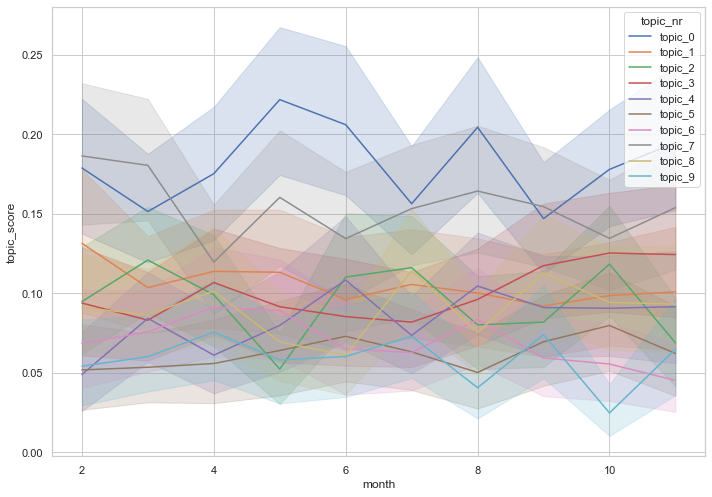

In [53]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

sns.lineplot(x="month", y="topic_score", hue="topic_nr", data=long)

plt.show()